<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Truck Trailer Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Truck Trailer Problem:* We aim to find the optimal trajectory of a truck with two trailers that starts horizontally aligned and has to park truck and trailer aligned vertically at a given target location in minimum time.                                               
The problem is inspired from the following paper: [FATROP : A Fast Constrained Optimal Control Problem Solver for Robot Trajectory Optimization and Control](https://arxiv.org/pdf/2303.16746) made for [Casadi](https://web.casadi.org/) software and [Fatrop](https://github.com/meco-group/fatrop) solver.                            
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

In [1]:
import Pkg
Pkg.activate("..")
include("./utils.jl");
using OptimalControlProblems
using Plots
using MKL
import HSL_jll
nh = 100;

  Activating project at `~/ENSEEIHT/Stage/CTBenchmarks.jl`


## 1. Solving with JuMP <a id='jump'></a>

In [ ]:
using JuMP , Ipopt

TruckJMP = truck_trailer(JuMPBackend();nh=nh)

set_optimizer(TruckJMP,Ipopt.Optimizer)
set_attribute(TruckJMP, "print_level", 5)
set_optimizer_attribute(TruckJMP,"tol",1e-8)
set_optimizer_attribute(TruckJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(TruckJMP,"max_iter",1000)
set_optimizer_attribute(TruckJMP,"mu_strategy","adaptive")
#set_attribute(TruckJMP, "hsllib", HSL_jll.libhsl_path)
#set_attribute(TruckJMP, "linear_solver", "ma57")
set_optimizer_attribute(TruckJMP, "print_timing_statistics", "yes")
set_optimizer_attribute(TruckJMP, "sb", "yes")

In [ ]:
println("Solving...")
optimize!(TruckJMP)
println()

# Display results
if termination_status(TruckJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(TruckJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(TruckJMP) == MOI.TIME_LIMIT && has_values(TruckJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(TruckJMP))
println()

#state
x2 = TruckJMP[:x2];
y2 = TruckJMP[:y2];
theta0 = TruckJMP[:theta0];
theta1 = TruckJMP[:theta1];
theta2 = TruckJMP[:theta2];
#control 
v0 = TruckJMP[:v0];
delta0 = TruckJMP[:delta0];

#co-state
d_x2 = TruckJMP[:d_x2];
d_y2 = TruckJMP[:d_y2];
d_theta0 = TruckJMP[:d_theta0];
d_theta1 = TruckJMP[:d_theta1];
d_theta2 = TruckJMP[:d_theta2];

tf = value(TruckJMP[:tf])
Δtt = value.(tf)/nh
t = Vector((0:nh)*Δtt); 

p = -[[ dual(d_x2[i]), dual(d_y2[i]), dual(d_theta0[i]), dual(d_theta1[i]), dual(d_theta2[i]) ] for i in 1:nh];
p = costateInterpolation(p, t);

x2 = Vector(value.(x2))
y2 = Vector(value.(y2))
theta0 = Vector(value.(theta0))
theta1 = Vector(value.(theta1))
theta2 = Vector(value.(theta2))

v0 = Vector(value.(v0))
delta0 = Vector(value.(delta0))

u = [ [ v0[i], delta0[i]] for i in 1:nh+1] ;

x =  [ [ x2[i], y2[i], theta0[i], theta1[i], theta2[i] ] for i in 1:nh+1] ;

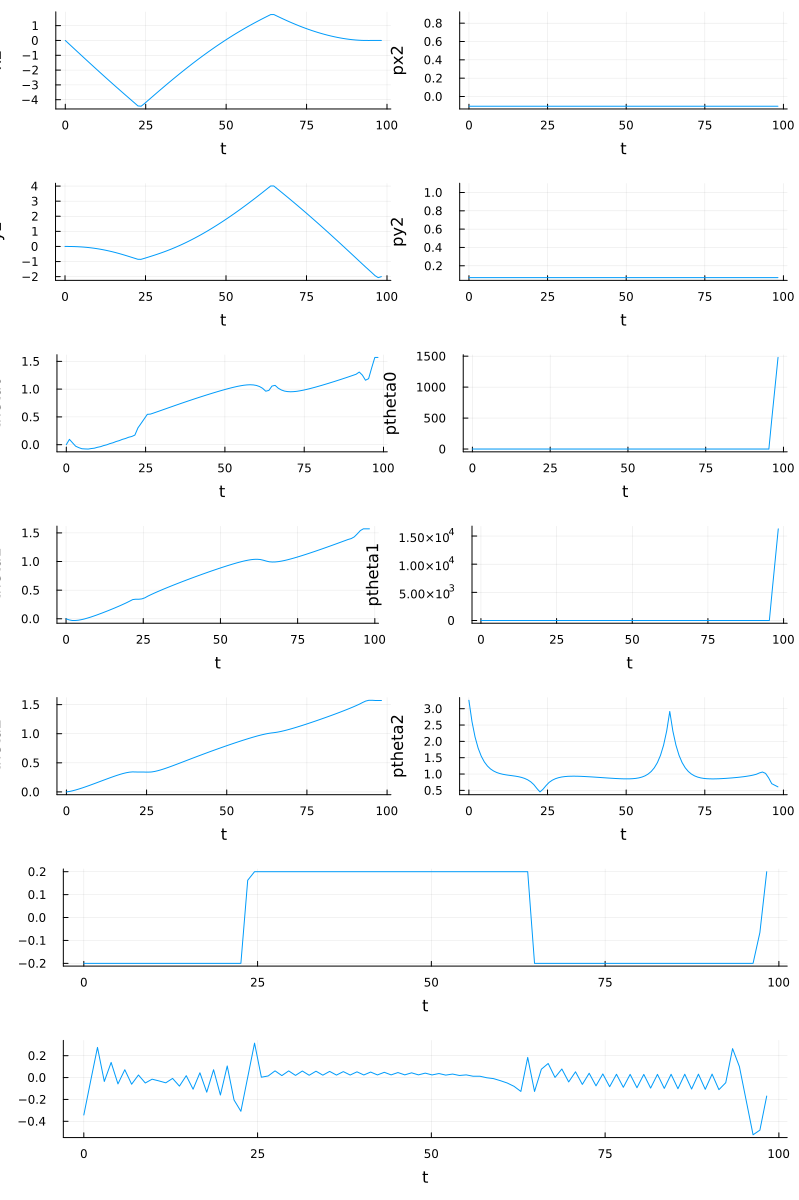

In [4]:
x2_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x2", legend = false)
y2_plot = plot(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "y2", legend = false)
theta0_plot = plot(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta0", legend = false)
theta1_plot = plot(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta1", legend = false)
theta2_plot = plot(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta2", legend = false)
px2_plot = plot(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px2", legend = false)
py2_plot = plot(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "py2", legend = false)
ptheta0_plot = plot(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta0", legend = false)
ptheta1_plot = plot(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta1", legend = false)
ptheta2_plot = plot(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta2", legend = false)
u1_plot = plot(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "v0", legend = false)
u2_plot = plot(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "delta0", legend = false)

layout = @layout [a b; c d; e f; g h; i j; m; n;]
ploting = plot(x2_plot, px2_plot, y2_plot, py2_plot, theta0_plot, ptheta0_plot, theta1_plot, ptheta1_plot, theta2_plot, ptheta2_plot, u1_plot, u2_plot, layout = layout)
ploting = plot!(ploting, size = (800, 1200))
display(ploting)

┌ Info: Saved animation to C:\Users\hajje\AppData\Local\Temp\jl_snsN4Bmxa3.gif
└ @ Plots C:\Users\hajje\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\hajje\\AppData\\Local\\Temp\\jl_snsN4Bmxa3.gif")
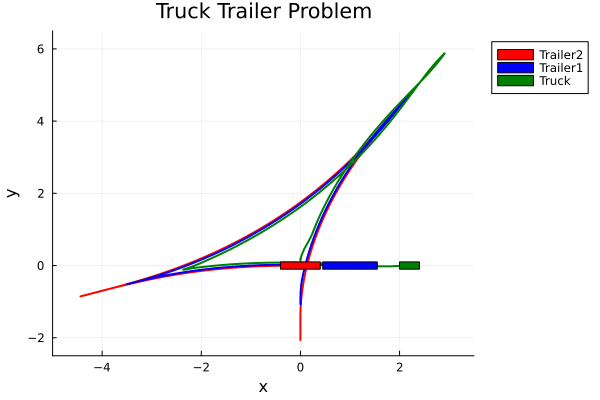

In [5]:
data = [0.4 0.1 0.2; #truck
        1.1 0.2 0.2; #trailer1
        0.8 0.1 0.2] #trailer2
L0 = data[1, 1]
M0 = data[1, 2]
W0 = data[1, 3]
L1 = data[2, 1]
M1 = data[2, 2]
W1 = data[2, 3]
L2 = data[3, 1]
M2 = data[3, 2]
W2 = data[3, 3]

x1 = [x2[j] + L2*cos(theta2[j]) + M1*cos(theta1[j]) for j in 1:nh+1]
y1 = [y2[j] + L2*sin(theta2[j]) + M1*sin(theta1[j]) for j in 1:nh+1]

x0 = [x1[j] + L1*cos(theta1[j]) + M0*cos(theta0[j]) for j in 1:nh+1]
y0 = [y1[j] + L1*sin(theta1[j]) + M0*sin(theta0[j]) for j in 1:nh+1]

# Function to get the vertices, rotated by angle θ
function get_vertices(x, y, θ, length , width)
    half_length = length / 2
    half_width = width / 2
    corners = [
        [-half_length, -half_width],
        [half_length, -half_width],
        [half_length, half_width],
        [-half_length, half_width],
        [-half_length, -half_width]
    ]
    cos_θ = cos(θ)
    sin_θ = sin(θ)
    rotated_corners = [
        (x + corner[1] * cos_θ - corner[2] * sin_θ, y + corner[1] * sin_θ + corner[2] * cos_θ)
        for corner in corners
    ]
    return rotated_corners
end


plot(x2, y2; linewidth = 2, legend = nothing, title = "Truck Trailer Problem", xlabel = "x", ylabel = "y", color = :red,
    xlims = (-5, 3.5), ylims = (-2.5, 6.5),label = "")
plot!(x1, y1; linewidth = 2, legend = nothing, color = :blue,label = "")
plot!(x0, y0; linewidth = 2, legend = nothing, color = :green,label = "")

# Create the animation
@gif for i in 1:length(x2)-1

    # Plot Trajectories
    plot(x2, y2; linewidth = 2, legend = nothing, title = "Truck Trailer Problem", xlabel = "x", ylabel = "y", color = :red,
        xlims = (-5, 3.5), ylims = (-2.5, 6.5),label = "")
    plot!(x1, y1; linewidth = 2, legend = nothing, color = :blue,label = "")
    plot!(x0, y0; linewidth = 2, legend = nothing, color = :green,label = "")

    # Plot the Trailer2
    x = x2[i]
    y = y2[i]

    θ = theta2[i]

    trailer2_vertices = get_vertices(x, y, θ, L2, W2)
    trailer2_x = [vertex[1] for vertex in trailer2_vertices]
    trailer2_y = [vertex[2] for vertex in trailer2_vertices]

    plot!(trailer2_x, trailer2_y; seriestype = :shape, color = :red , legend = :outertopright, label="Trailer2")

    # Plot the Trailer1
    x = x1[i]
    y = y1[i]

    θ = theta1[i]

    trailer1_vertices = get_vertices(x, y, θ, L1, W1)
    trailer1_x = [vertex[1] for vertex in trailer1_vertices]
    trailer1_y = [vertex[2] for vertex in trailer1_vertices]

    plot!(trailer1_x, trailer1_y; seriestype = :shape, color = :blue, legend = :outertopright, label="Trailer1")

    # Plot the Truck
    x = x0[i]
    y = y0[i]

    θ = theta0[i]

    truck_vertices = get_vertices(x, y, θ, L0, W0)
    truck_x = [vertex[1] for vertex in truck_vertices]
    truck_y = [vertex[2] for vertex in truck_vertices]

    plot!(truck_x, truck_y; seriestype = :shape, color = :green, legend = :outertopright, label="Truck")
    

end every nh ÷ min(nh, 100)

## 2. Solving with OptimalControl <a id='oc'></a>

In [6]:
using OptimalControl, NLPModelsIpopt
docp, TruckOC = truck_trailer(OptimalControlBackend();nh=nh);

In [ ]:
# Solve the problem
nlp_sol = NLPModelsIpopt.ipopt(
    TruckOC;
    print_level=5,
    tol=1e-8,
    mu_strategy="adaptive",
    sb="yes",
    constr_viol_tol=1e-6,
    max_iter=1000,
    print_timing_statistics="yes",
    #linear_solver="ma57",
    #hsllib=HSL_jll.libhsl_path,
)

This is Ipopt version 3.14.16, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     7213
Number of nonzeros in inequality constraint Jacobian.:      404
Number of nonzeros in Lagrangian Hessian.............:     2121

Total number of variables............................:     1011
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      606
                     variables with only upper bounds:        0
Total number of equality constraints.................:      811
Total number of inequality constraints...............:      202
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      202
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e-01 2.00e+00 1.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
Rea

"Execution stats: first-order stationary"

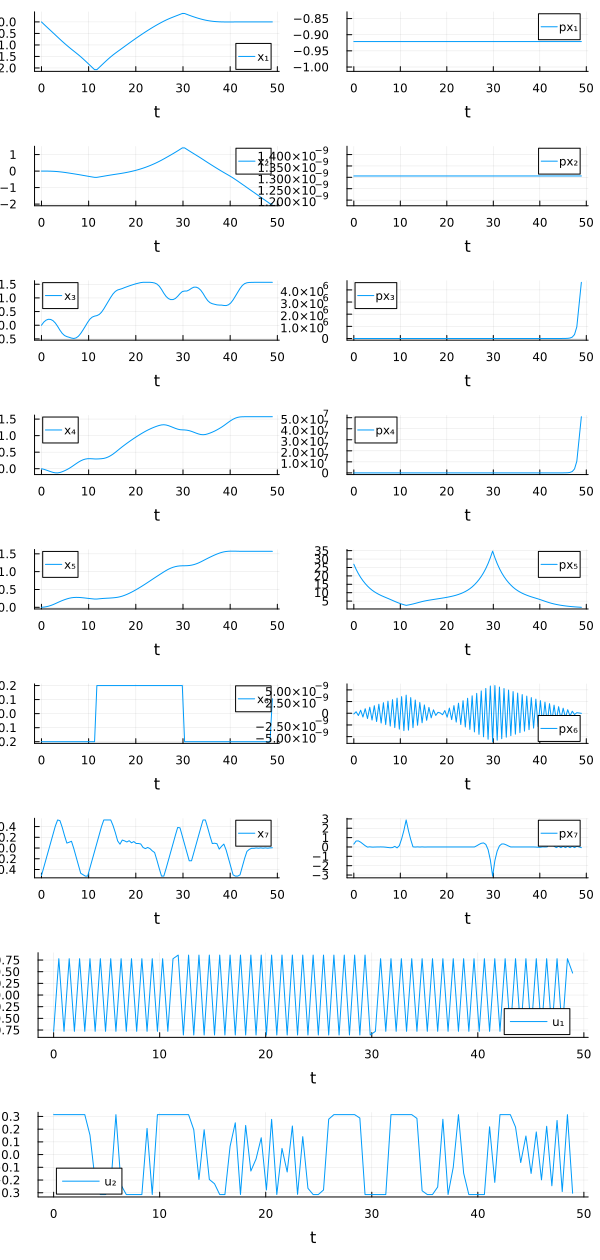

In [ ]:
# Plot results
sol = build_OCP_solution(docp; primal=nlp_sol.solution, dual=nlp_sol.multipliers)
plot(sol)

## 3. Comparison <a id='comp'></a>

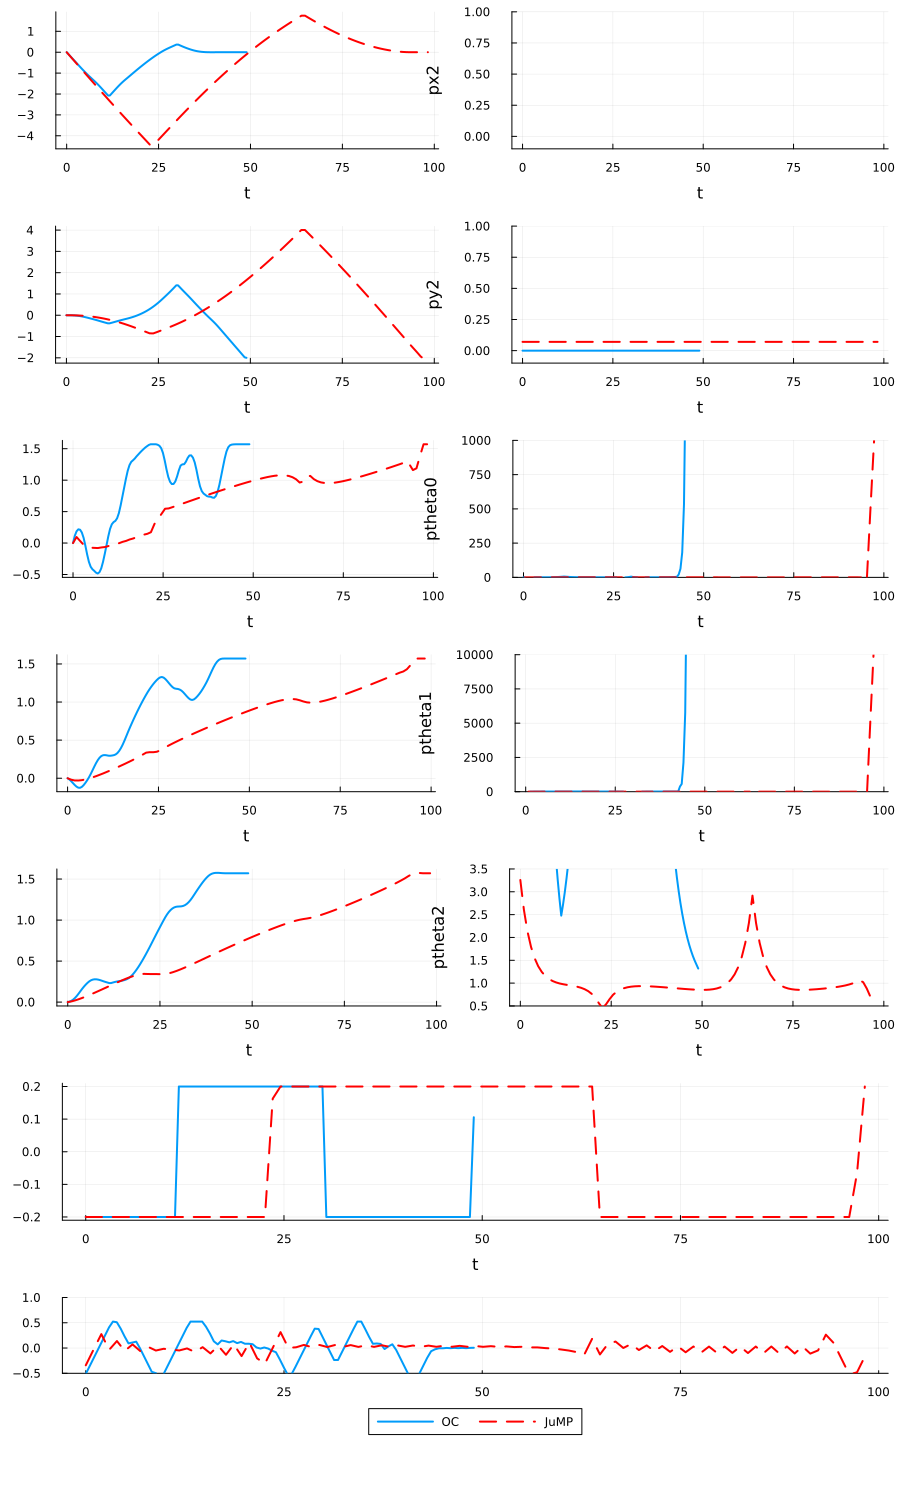

In [9]:
p_x2 = plot(plot(sol)[1],line = 2)
p_x2 = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p_y2 = plot(plot(sol)[2],line = 2)
p_y2 = plot!(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "y2", legend = false,line = 2, color = "red",linestyle=:dash)

p_theta0 = plot(plot(sol)[3],line = 2)
p_theta0 = plot!(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta0", legend = false,line = 2, color = "red",linestyle=:dash)

p_theta1 = plot(plot(sol)[4],line = 2)
p_theta1 = plot!(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta1", legend = false,line = 2, color = "red",linestyle=:dash)

p_theta2 = plot(plot(sol)[5],line = 2)
p_theta2 = plot!(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta2", legend = false,line = 2, color = "red",linestyle=:dash)

p_px2 = plot(plot(sol)[8],line = 2, ylim = (-0.1,1))
p_px2 = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p_py2 = plot(plot(sol)[9],line = 2, ylim = (-0.1,1))
p_py2 = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "py2", legend = false,line = 2, color = "red",linestyle=:dash)

p_ptheta0 = plot(plot(sol)[10],line = 2, ylim = (-0.1,1000))
p_ptheta0 = plot!(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta0", legend = false,line = 2, color = "red",linestyle=:dash)

p_ptheta1 = plot(plot(sol)[11],line = 2, ylim = (-0.1,10000))
p_ptheta1 = plot!(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta1", legend = false,line = 2, color = "red",linestyle=:dash)

p_pheta2 = plot(plot(sol)[12],line = 2, ylim = (0.5,3.5))
p_pheta2 = plot!(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "ptheta2", legend = false,line = 2, color = "red",linestyle=:dash)

p_v0 = plot(plot(sol)[6],line = 2, ylim = (-0.21,0.21))
p_v0 = plot!(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "v0", legend = false,line = 2, color = "red",linestyle=:dash)

p_delta0 = plot(plot(sol)[7], label ="OC",line = 2,ylim = (-0.5,1))
p_delta0 = plot!(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "delta0", legend = false,label = "JuMP",line = 2, color = "red",linestyle=:dash)
p_delta0 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [p_x2 p_px2; p_y2 p_py2; p_theta0 p_ptheta0; p_theta1 p_ptheta1; p_theta2 p_pheta2; p_v0; p_delta0]

x_plot = plot(p_x2, p_px2, p_y2, p_py2, p_theta0, p_ptheta0, p_theta1, p_ptheta1, p_theta2, p_pheta2, p_v0, p_delta0, layout = layout)
x_plot = plot!(size = (900, 1500))

display(x_plot)